In [ ]:
import pandas as pd
import shap
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif, mutual_info_classif, chi2
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import KFold

In [2]:
data = pd.read_csv('alzheimers_disease_data.csv')

In [3]:
data.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


In [4]:
data.columns

Index(['PatientID', 'Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI',
       'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
       'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease',
       'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP',
       'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL',
       'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment',
       'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion',
       'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks',
       'Forgetfulness', 'Diagnosis', 'DoctorInCharge'],
      dtype='object')

In [5]:
drop = ['PatientID','Ethnicity', 'EducationLevel', 'Gender','DoctorInCharge' ]
try:
    data.drop(drop, axis = 1, inplace=True)
except KeyError:
    pass
data.columns

Index(['Age', 'BMI', 'Smoking', 'AlcoholConsumption', 'PhysicalActivity',
       'DietQuality', 'SleepQuality', 'FamilyHistoryAlzheimers',
       'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury',
       'Hypertension', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal',
       'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE',
       'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL',
       'Confusion', 'Disorientation', 'PersonalityChanges',
       'DifficultyCompletingTasks', 'Forgetfulness', 'Diagnosis'],
      dtype='object')

In [6]:
data.head()

,Age,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryAlzheimers,CardiovascularDisease,Diabetes,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,73,22.927749,0,13.297218,6.327112,1.347214,9.025679,0,0,1,...,6.518877,0,0,1.725883,0,0,0,1,0,0
1,89,26.827681,0,4.542524,7.619885,0.518767,7.151293,0,0,0,...,7.118696,0,0,2.592424,0,0,0,0,1,0
2,73,17.795882,0,19.555085,7.844988,1.826335,9.673574,1,0,0,...,5.895077,0,0,7.119548,0,1,0,1,0,0
3,74,33.800817,1,12.209266,8.428001,7.435604,8.392554,0,0,0,...,8.965106,0,1,6.481226,0,0,0,0,0,0
4,89,20.716974,0,18.454356,6.310461,0.795498,5.597238,0,0,0,...,6.045039,0,0,0.014691,0,0,1,1,0,0


In [7]:
categorical_cols = [col for col in data.columns if set(data[col].unique()) >= {0, 1}]
numerical_cols = [col for col in data.columns if set(data[col].unique()) != {0, 1}]

In [8]:
cat_rows = data[categorical_cols]
num_rows = data[numerical_cols]

**FILTERING OUTLIERS BASED ON INTER QUARTILE RANGE OF FEATURES**

In [9]:
def filter_outliers(data):
    drop_rows = pd.DataFrame()

    for i in data.columns:
        q1 = data[i].quantile(0.25)
        q3 = data[i].quantile(0.75)
        iqr = q3 - q1
        lower_limit = q1 - 1.5*iqr
        upper_limit = q3 + 1.5*iqr
        drop_rows = pd.concat([data[(data[i] < lower_limit) & (data[i] > upper_limit)], drop_rows])

    return drop_rows

In [10]:
drops_rows = filter_outliers(data)
data.drop(drops_rows, axis = 1, inplace = True)

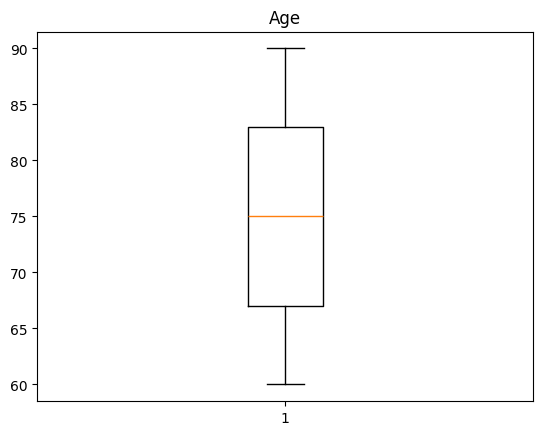

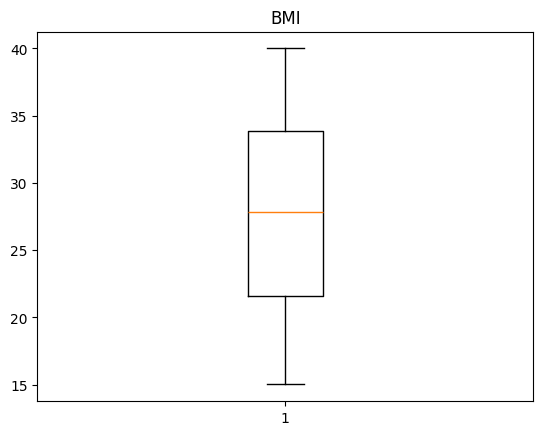

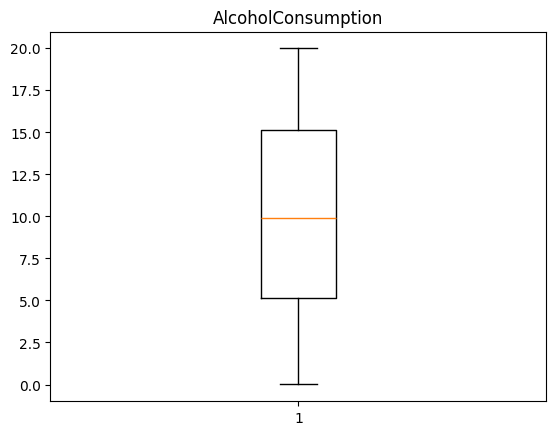

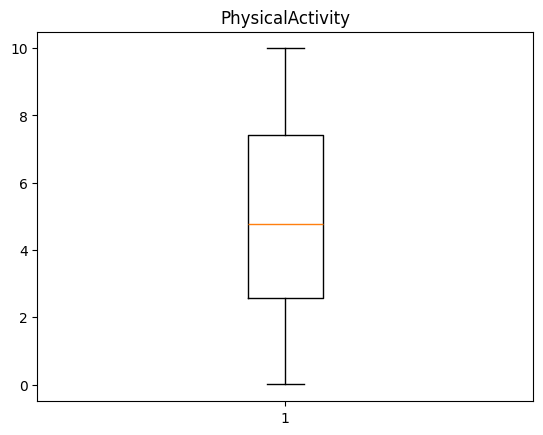

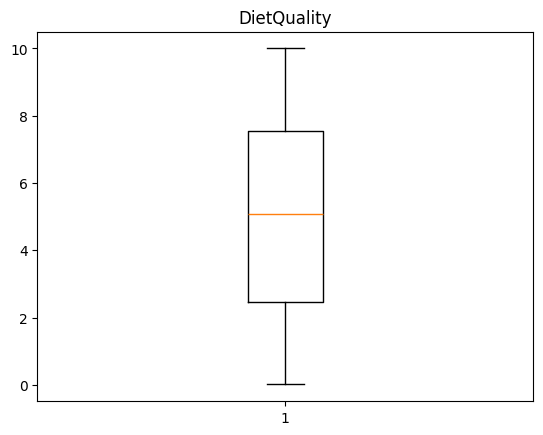

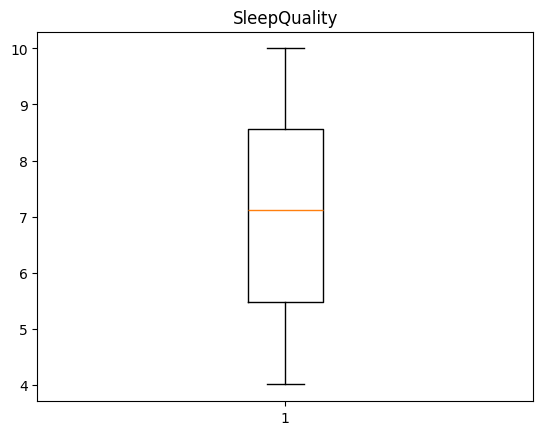

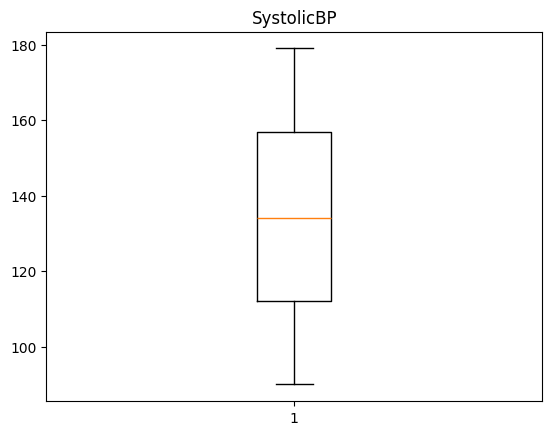

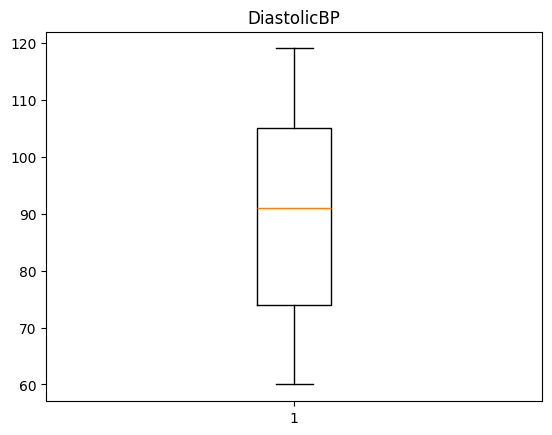

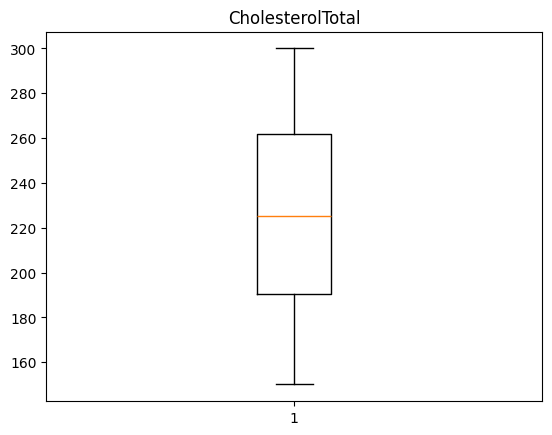

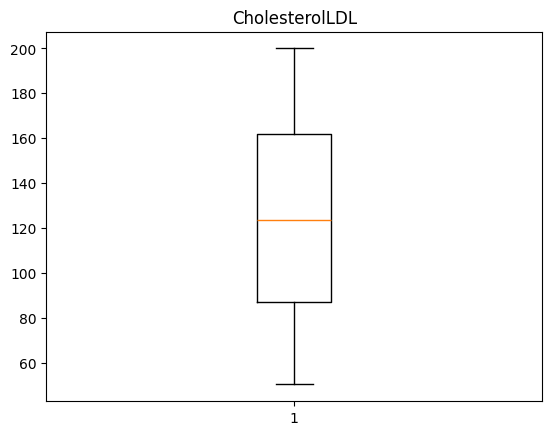

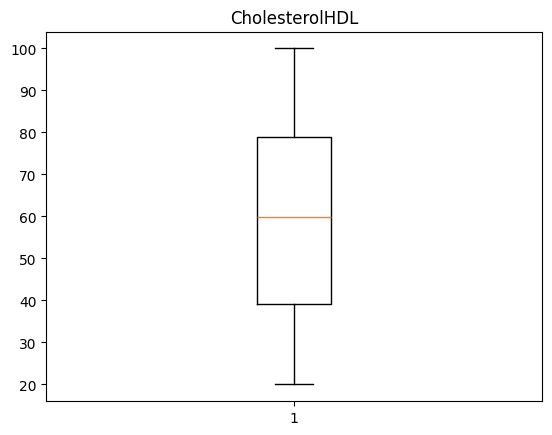

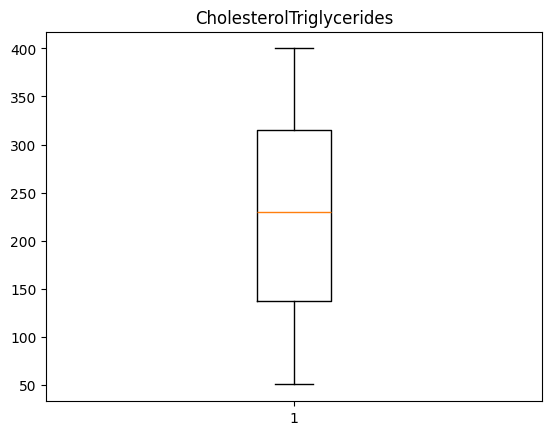

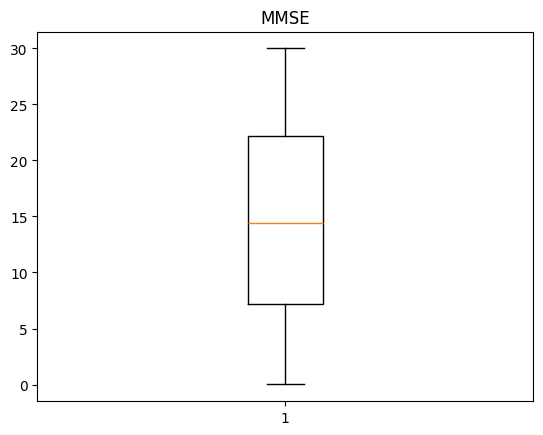

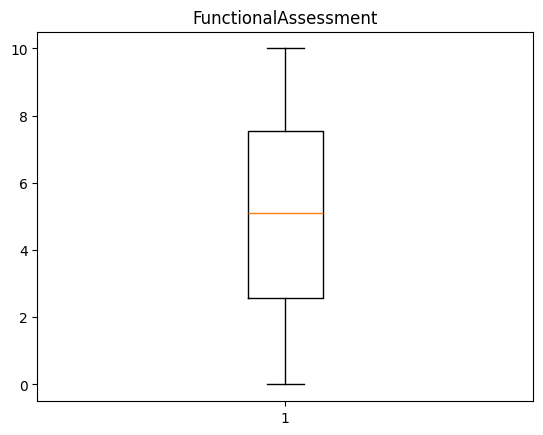

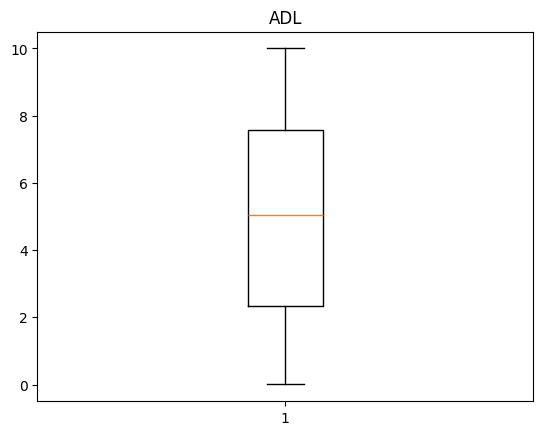

In [11]:
for i in num_rows.columns:    
    plt.figure()
    plt.boxplot(num_rows[i])
    plt.title(i)
    plt.show()

In [12]:
for i in cat_rows.columns:
    
    print(cat_rows[i].unique())

[0 1]
[0 1]
[0 1]
[1 0]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]
[0 1]
[0 1]


In [13]:
sc_scaled_num_rows = pd.DataFrame(StandardScaler().fit_transform(num_rows), columns=num_rows.columns)
mm_scaaled_num_rows = pd.DataFrame(MinMaxScaler().fit_transform(num_rows), columns=num_rows.columns)

In [14]:
sc_scaled_num_rows

,Age,BMI,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,SystolicBP,DiastolicBP,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,MMSE,FunctionalAssessment,ADL
0,-0.212368,-0.655225,0.565923,0.492525,-1.253593,1.119918,0.298159,-1.014750,0.403677,-1.572661,-1.114429,-0.648199,0.779037,0.497506,-1.104434
1,1.567757,-0.114751,-0.954895,0.945093,-1.538442,0.056836,-0.742572,-1.469595,0.140248,1.593119,0.845730,0.650721,0.680297,0.704907,-0.810601
2,-0.212368,-1.366428,1.653006,1.023896,-1.088855,1.487380,-1.359301,1.486898,1.386812,0.668569,0.445615,-1.418585,-0.859222,0.281813,0.724491
3,-0.101111,0.851625,0.376930,1.227995,0.839804,0.760833,-0.626935,1.430043,-1.542715,-1.360103,0.388780,0.483468,-0.088723,1.343346,0.508044
4,1.567757,-0.961607,1.461793,0.486696,-1.443293,-0.824566,-1.552029,1.543754,0.291653,-0.725756,-0.111924,0.617060,-0.143712,0.333665,-1.684679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144,-1.547463,1.589030,-1.472807,-0.304649,0.537127,0.274767,-0.472753,0.634063,1.299701,-0.679609,0.063957,0.061185,-1.574000,-1.674022,-0.166194
2145,0.010147,-1.357833,1.516149,-1.246106,-0.718090,0.853112,0.683615,0.918342,-0.912555,-0.667149,1.477761,1.370158,-0.963527,1.247350,1.431627
2146,0.232663,-1.687864,-0.945836,1.738405,1.075131,-0.726886,-0.742572,1.600609,0.278072,0.736484,1.738352,0.652402,0.261971,-1.074634,0.018099
2147,0.343921,-1.712334,-0.237109,0.502036,-1.282402,0.721313,-1.205119,0.349785,0.399688,-1.657260,0.943104,-0.814293,-1.245437,0.032446,-0.406078


In [15]:
mm_scaaled_num_rows

,Age,BMI,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,SystolicBP,DiastolicBP,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,MMSE,FunctionalAssessment,ADL
0,0.433333,0.316960,0.665183,0.633375,0.133931,0.837564,0.584270,0.203390,0.615567,0.039538,0.171039,0.319802,0.715606,0.652102,0.172486
1,0.966667,0.473058,0.227170,0.762862,0.050995,0.525021,0.280899,0.067797,0.540822,0.956205,0.738026,0.698711,0.687251,0.712108,0.259154
2,0.433333,0.111553,0.978276,0.785408,0.181896,0.945597,0.101124,0.949153,0.894520,0.688497,0.622290,0.095072,0.245145,0.589697,0.711936
3,0.466667,0.752163,0.610751,0.843804,0.743443,0.731994,0.314607,0.932203,0.063302,0.101085,0.605851,0.649922,0.466410,0.896823,0.648094
4,0.966667,0.228472,0.923204,0.631707,0.078698,0.265892,0.044944,0.966102,0.583781,0.284763,0.461019,0.688892,0.450619,0.604699,0.001341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144,0.033333,0.965137,0.078006,0.405291,0.655316,0.589092,0.359551,0.694915,0.869803,0.298125,0.511894,0.526737,0.039881,0.023830,0.449224
2145,0.500000,0.114035,0.938860,0.135925,0.289848,0.759124,0.696629,0.779661,0.242102,0.301733,0.920845,0.908578,0.215192,0.869049,0.920508
2146,0.566667,0.018717,0.229779,0.989841,0.811960,0.294609,0.280899,0.983051,0.579928,0.708162,0.996222,0.699201,0.567120,0.197246,0.503582
2147,0.600000,0.011650,0.433901,0.636096,0.125543,0.720376,0.146067,0.610169,0.614435,0.015042,0.766192,0.271351,0.134235,0.517550,0.378469


**FEATURE IMPORTANCE SCORES**

In [16]:
X_num = num_rows
y = cat_rows['Diagnosis']

f_values, p_values = f_classif(X_num, y)

anova_results = pd.DataFrame({
    'Feature': X_num.columns,
    'F-value': f_values,
    'p-value': p_values
}).sort_values(by='F-value', ascending=False)

print(anova_results)

                     Feature     F-value       p-value
13      FunctionalAssessment  329.785969  1.134785e-68
14                       ADL  266.590232  1.396884e-56
12                      MMSE  127.915191  7.537248e-29
5               SleepQuality    6.887456  8.741801e-03
10            CholesterolHDL    3.900444  4.840127e-02
9             CholesterolLDL    2.197454  1.383856e-01
1                        BMI    1.490932  2.222060e-01
11  CholesterolTriglycerides    1.104156  2.934742e-01
6                 SystolicBP    0.523642  4.693709e-01
4                DietQuality    0.155343  6.935202e-01
2         AlcoholConsumption    0.124605  7.241273e-01
8           CholesterolTotal    0.087793  7.670310e-01
3           PhysicalActivity    0.075885  7.829796e-01
0                        Age    0.064675  7.992790e-01
7                DiastolicBP    0.060144  8.062912e-01


In [17]:
mi_scores = mutual_info_classif(X_num, y)

mi_results = pd.DataFrame({
    'Feature': X_num.columns,
    'Mutual Information': mi_scores
}).sort_values(by='Mutual Information', ascending=False)

print(mi_results)

                     Feature  Mutual Information
13      FunctionalAssessment            0.095454
14                       ADL            0.076564
12                      MMSE            0.066278
2         AlcoholConsumption            0.017780
10            CholesterolHDL            0.017349
7                DiastolicBP            0.012884
5               SleepQuality            0.009691
3           PhysicalActivity            0.007947
8           CholesterolTotal            0.000338
0                        Age            0.000000
1                        BMI            0.000000
4                DietQuality            0.000000
6                 SystolicBP            0.000000
9             CholesterolLDL            0.000000
11  CholesterolTriglycerides            0.000000


In [18]:
target = cat_rows['Diagnosis']
categorical = cat_rows.drop(['Diagnosis'], axis = 1)

In [19]:
target

0       0
1       0
2       0
3       0
4       0
       ..
2144    1
2145    1
2146    1
2147    1
2148    0
Name: Diagnosis, Length: 2149, dtype: int64

In [20]:
chi2_scores, p_values = chi2(categorical, target)

chi2_results = pd.DataFrame({
    'Feature': categorical.columns,
    'Chi-Squared Score': chi2_scores,
    'p-value': p_values
}).sort_values(by='Chi-Squared Score', ascending=False)

print("Chi-Squared Test Results:")
print(chi2_results)

Chi-Squared Test Results:
                      Feature  Chi-Squared Score       p-value
7            MemoryComplaints         160.142705  1.053099e-36
8          BehavioralProblems          91.203581  1.296254e-21
6                Hypertension           2.250784  1.335468e-01
2       CardiovascularDisease           1.823618  1.768832e-01
3                    Diabetes           1.811731  1.783008e-01
1     FamilyHistoryAlzheimers           1.739406  1.872141e-01
10             Disorientation           1.099025  2.944802e-01
5                  HeadInjury           0.893976  3.444022e-01
11         PersonalityChanges           0.776523  3.782066e-01
9                   Confusion           0.628701  4.278322e-01
12  DifficultyCompletingTasks           0.148688  6.997919e-01
4                  Depression           0.059660  8.070343e-01
0                     Smoking           0.036192  8.491191e-01
13              Forgetfulness           0.000188  9.890485e-01


In [21]:
mi_scores_cat = mutual_info_classif(categorical, y)

mi_results_cat = pd.DataFrame({
    'Feature': categorical.columns,
    'Mutual Information': mi_scores_cat
}).sort_values(by='Mutual Information', ascending=False)

print(mi_results_cat)

                      Feature  Mutual Information
7            MemoryComplaints            0.039559
1     FamilyHistoryAlzheimers            0.009381
5                  HeadInjury            0.009024
0                     Smoking            0.007617
8          BehavioralProblems            0.005029
9                   Confusion            0.002989
2       CardiovascularDisease            0.002863
12  DifficultyCompletingTasks            0.002275
3                    Diabetes            0.000000
4                  Depression            0.000000
6                Hypertension            0.000000
10             Disorientation            0.000000
11         PersonalityChanges            0.000000
13              Forgetfulness            0.000000


**SELECTING FEATURES WITH HIGH SCORES**

In [22]:
selected_cat_cols = ['MemoryComplaints', 'BehavioralProblems']
selected_num_cols = ['FunctionalAssessment', 'ADL', 'MMSE']

In [23]:
final_data = pd.concat([cat_rows[selected_cat_cols], num_rows[selected_num_cols]], axis = 1)

In [24]:
final_data.shape

(2149, 5)

In [25]:
trainx, testx, trainy, testy = train_test_split(final_data, target, train_size = 0.8, shuffle = True)

In [26]:
valx, testx, valy, testy = train_test_split(testx, testy, train_size=0.5, shuffle = True)

**TUNING DECISION TREE**

In [27]:
accuracy = 0.9

def tune_depth():
 depth = 0
 accuracy = 0

 for i in range(5, 100):

    tree2 = DecisionTreeClassifier(max_depth=i)
    tree2.fit(trainx, trainy)
    predictions = tree2.predict(valx)
    a = accuracy_score(predictions, valy)

    if a > accuracy:
      depth = i
      accuracy = a

 return depth

In [28]:
depth = tune_depth()

In [29]:
tree = DecisionTreeClassifier(max_depth=depth)
tree.fit(trainx, trainy)

DecisionTreeClassifier(max_depth=5)

In [30]:
print(classification_report(tree.predict(trainx), trainy))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1120
           1       0.94      0.95      0.95       599

    accuracy                           0.96      1719
   macro avg       0.96      0.96      0.96      1719
weighted avg       0.96      0.96      0.96      1719



In [31]:
predcitions = tree.predict(testx)

In [32]:
print(classification_report(testy, predcitions))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       145
           1       0.96      0.93      0.94        70

    accuracy                           0.96       215
   macro avg       0.96      0.95      0.96       215
weighted avg       0.96      0.96      0.96       215



**FEATURE IMPORTANCES**

In [33]:
feature_importance = tree.feature_importances_

<Axes: >

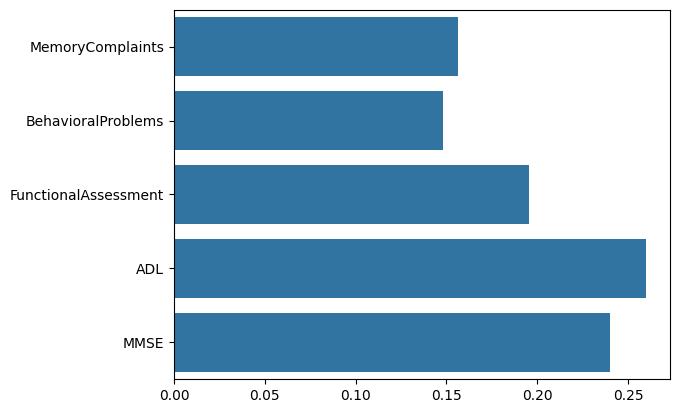

In [34]:
sns.barplot(x = feature_importance, y = ['MemoryComplaints',
 'BehavioralProblems',
 'FunctionalAssessment',
 'ADL',
 'MMSE'])

In [35]:
y = list(final_data.columns)

In [36]:
shap_vals = shap.TreeExplainer(tree).shap_values(final_data)

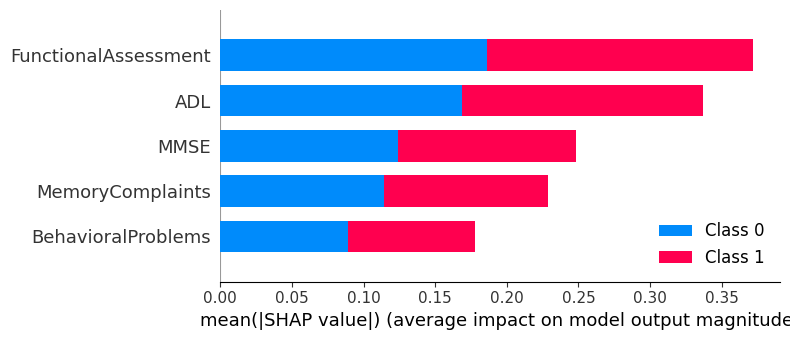

In [37]:
shap.summary_plot(shap_vals, final_data)